In [15]:
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [16]:
def make_basis(n):
    basis=list(it.product([-1/2,1/2],repeat=n))
    inv={v:k for k,v in enumerate(basis)}
    return basis,inv

def get_bonds(width, height):
    if width%2!=0 or height%2!=0:
        raise ValueError("width and height must be even")
    bonds=[]
    for i in range(width):
        for j in range(height):
            i2,j2=(i+1)%width,j
            bonds.append((i+j*width,i2+j2*width,"j2"))
            i2,j2=i,(j+1)%height
            bonds.append((i+j*width,i2+j2*width,("j1" if j%2==0 else "j2")))
    return bonds

def make_H(width, height, j1):
    basis,inv=make_basis(width*height)
    bonds=get_bonds(width,height)
    rows=[]
    cols=[]
    data=[]
    for c,ket in enumerate(basis):
        diag=0
        for i,j,kind in bonds:
            #diagonal term
            if kind=="j1":
                diag+=ket[i]*ket[j]*j1
            elif kind=="j2":
                diag+=ket[i]*ket[j]
            #off-diagonal term
            if ket[i]!=ket[j]:
                bra=list(ket)
                bra[i],bra[j]=bra[j],bra[i]
                r=inv[tuple(bra)]
                rows.append(r)
                cols.append(c)
                data.append((1 if kind=="j1" else j1)/2)
        rows.append(c)
        cols.append(c)
        data.append(diag)
    return sp.sparse.csr_matrix((data,(rows,cols)),shape=(len(basis),len(basis)))
def make_M(width, height):
    basis,inv=make_basis(width*height)
    rows=[]
    cols=[]
    data=[]
    for c,ket in enumerate(basis):
        value=0
        for x in range(width):
            for y in range(height):
                value+=ket[x+y*width]*(-1)**(x+y)
        rows.append(c)
        cols.append(c)
        data.append(np.abs(value))
    return sp.sparse.csr_matrix((data,(rows,cols)),shape=(len(basis),len(basis)))  


In [17]:
make_H(2,4,1)

<256x256 sparse matrix of type '<class 'numpy.float64'>'
	with 1792 stored elements in Compressed Sparse Row format>

In [18]:
def staggered_magnetization(width, height, beta, j1):
    H=make_H(width,height,j1).todense()
    M=make_M(width,height).todense()
    eigvals,eigvecs=np.linalg.eigh(H)
    Z=np.sum(np.exp(-beta*eigvals))
    rho=np.exp(-beta*eigvals)/Z
    total=0
    for vec,r in zip(eigvecs.T,rho):
        total+=np.conjugate(vec)@M@vec.T*r
    return float(total)

/tmp/ipykernel_5331/84633176.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(total)


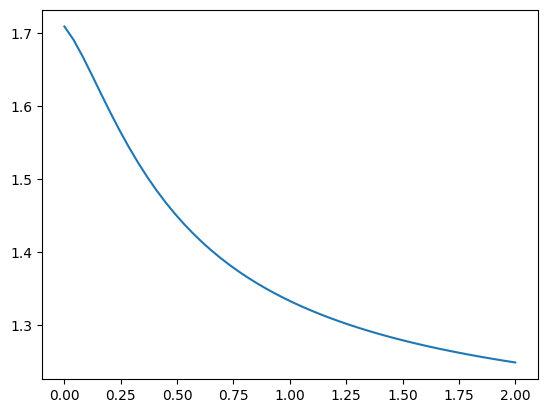

In [19]:
js=np.linspace(0,2,50)
ms=[staggered_magnetization(2,2,12,j) for j in js]
plt.plot(js,ms)


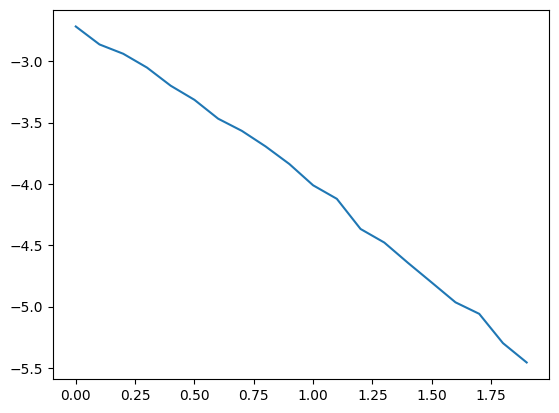

In [24]:
data=np.loadtxt("data.csv", delimiter=",")
x=data[:,0]
y=data[:,1]
plt.plot(x,y)

In [21]:
def energy(width, height, beta, j1):
    H=make_H(width,height,j1).todense()
    eigvals=np.linalg.eigvalsh(H)
    Z=np.sum(np.exp(-beta*eigvals))
    rho=np.exp(-beta*eigvals)/Z
    return sum(eigvals*rho)

In [22]:
H=make_H(2,2,1).todense()
M=make_M(2,2).todense()
eigvals,eigvecs=np.linalg.eigh(H)
#normalize the eigen vectors
#eigvecs/=np.linalg.norm(eigvecs,axis=0)
beta=12
Z=np.sum(np.exp(-beta*eigvals))
rho=np.exp(-beta*eigvals)/Z
total=0
for vec,r in zip(eigvecs.T,rho):
    total+=np.conjugate(vec)@M@vec.T*r
float(total)
for vec in eigvecs.T:
    print(np.linalg.norm(vec))

0.9999999999999999
1.0000000000000002
0.9999999999999998
1.0
0.9999999999999999
1.0
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999994
1.0000000000000002
1.0000000000000002
0.9999999999999997
1.0
1.0
0.9999999999999997


/tmp/ipykernel_5331/648316310.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(total)


[-0.8826702260655171, -0.9217679689446375, -0.9672265232664484, -1.0188515196917733, -1.0764213953744646, -1.1396905141114697, -1.2083925689152981, -1.2822441783140193, -1.3609485854564196, -1.4441993706123646, -1.5316840926336437, -1.623087782903388, -1.7180962256283507, -1.8163989703049885, -1.917692035075795, -2.021680272774273, -2.1280793840976315, -2.2366175740185787, -2.3470368578525007, -2.4590940320722954, -2.572561331877005, -2.687226802656453, -2.802894415930299, -2.9193839622278586, -3.036530753913312, -3.1541851703758748, -3.2722120765297977, -3.3904901434319843, -3.5089110972341877, -3.6273789198267314, -3.745809021556892, -3.864127403442638, -3.982269823448815, -4.100180978717365, -4.217813713193863, -4.335128257895763, -4.452091509135808, -4.568676348345436, -4.684861005728314, -4.800628468796468, -4.915965935881081, -5.030864313943376, -5.145317759415805, -5.2593232603559805, -5.372880257874237, -5.485990304579371, -5.598656757658085, -5.710884504145072, -5.822679715938

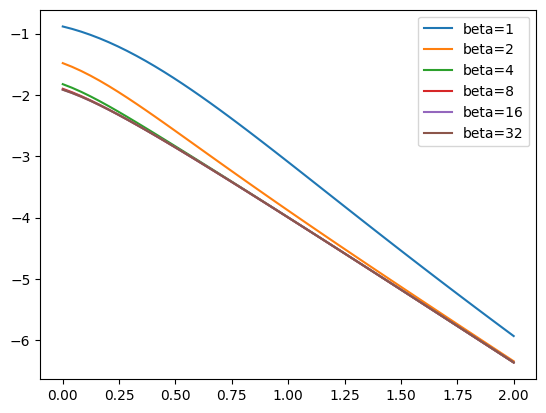

In [23]:
#for beta in [1,2,4,8,16,32]:
with 15 as beta:
    js=np.linspace(0,2,50)
    ms=[energy(2,2,beta,j1) for j1 in js]
    plt.plot(js,ms,label=f"beta={beta}")
    print(ms)
plt.legend()
plt.show()
    